In [1]:
import os
import re

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

from pandas.core.dtypes.common import is_numeric_dtype
from sklearn.feature_selection import mutual_info_regression, f_regression, SelectKBest
from sklearn.preprocessing import MinMaxScaler

%load_ext autoreload
%autoreload 2
import default_style

font sizes set


In [2]:
DATA_FOLDER = 'dataset'
IMAGE_FOLDER = 'images'
DATASET = os.path.join(DATA_FOLDER, 'outliers_removed.csv')

In [3]:
df = pd.read_csv(DATASET)

df.repetition = df.repetition.apply(str)

numerical_attr_list = [col for col in df.columns if is_numeric_dtype(df[col])]
categorical_attr_list = [col for col in df.columns if not is_numeric_dtype(df[col])]

# one hot encoding
df_reg = df.drop(columns=categorical_attr_list)
# df_reg = df_reg.join(pd.get_dummies(df[categorical_attr_list], columns=categorical_attr_list).astype(int))

df_reg.head()

,frame_count,sum,mean,std,min,max,q01,q05,q25,q75,...,log_lag1_max,log_lag1_q01,log_lag1_q05,log_lag1_q95,log_lag1_q99,log_lag1_kur,log_lag1_kur_w2,log_lag1_kur_w3,log_lag1_min_w4,log_lag1_kur_w4
0,158558,0.145081,9.150000e-07,0.004001,-0.038422,0.040588,-0.012586,-0.005890,-0.000031,0.0,...,-1.737299,-2.791174,-3.285001,-3.285001,-2.767262,1.714222,1.023989,1.340758,-4.214420,0.794669
1,160160,0.114319,7.137790e-07,0.004283,-0.042603,0.048157,-0.013550,-0.006104,-0.000031,0.0,...,-1.965222,-2.759575,-3.260177,-3.260177,-2.737299,1.624565,1.059026,1.472091,-4.214420,0.970269
2,156956,0.149963,9.554485e-07,0.005084,-0.037018,0.058472,-0.015822,-0.007294,0.000000,0.0,...,-1.710629,-2.561207,-3.135239,-3.135239,-2.537726,1.736630,1.113757,1.190945,-4.038329,1.027423
3,152152,0.139618,9.176213e-07,0.004886,-0.036652,0.062683,-0.014923,-0.006714,-0.000031,0.0,...,-1.695906,-2.524224,-3.135239,-3.135239,-2.519815,1.724345,1.085937,1.236662,-4.038329,0.715249
4,169769,0.137665,8.108948e-07,0.002956,-0.026245,0.026215,-0.009399,-0.004364,-0.000031,0.0,...,-2.176993,-2.902666,-3.401507,-3.401507,-2.871997,1.647124,1.113935,1.345926,-4.214420,0.706650


In [4]:
features_to_correct = ['stft_min', 'sc_min']
(df[features_to_correct] < 0).any()

stft_min    False
sc_min      False
dtype: bool

# stft_min

In [5]:
TARGET = 'stft_min'

# drop quantile columns with high percentage of zeros (20%)
zero_percentage = (df_reg == 0).mean()
to_drop = [col for col in df_reg.columns if zero_percentage[col] > 0.2 and re.search(r'q\d{2}', col)]
to_drop.append('sc_min')
df_reg = df_reg.drop(columns=to_drop)
to_drop

['mfcc_q50',
 'sc_q01',
 'sc_q05',
 'stft_q01',
 'stft_q05',
 'mfcc_q25_w1',
 'mfcc_q50_w1',
 'sc_q01_w1',
 'sc_q05_w1',
 'sc_q25_w1',
 'stft_q01_w1',
 'stft_q05_w1',
 'q50_w2',
 'q50_w3',
 'lag1_q50_w3',
 'q75_w4',
 'sc_min']

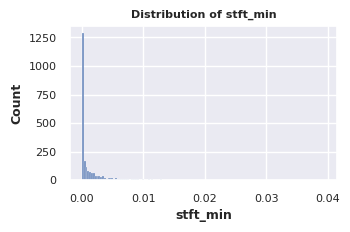

In [6]:
sns.histplot(data=df, x=df[TARGET])
plt.xlabel(f'{TARGET}')
plt.ylabel('Count')
plt.title(f'Distribution of {TARGET}')
plt.savefig(os.path.join(IMAGE_FOLDER, 'initial_stft_min_distr.pdf'), format='pdf')
plt.show()

In [20]:
from sklearn.model_selection import train_test_split

# Take all numerical attributes except for TARGET
df_target_excluded = df_reg[list(set([col for col in df_reg.columns if is_numeric_dtype(df_reg[col])]) - set([TARGET]))]
X = df_target_excluded.values
y = df[TARGET].values

# identifies bad rows, the ones han=ving a null TARGET
bad_kids = (y==0)

# Extracts bad rows
X_to_predict = X[bad_kids]

# Takes good ones
X_non_zero = X[~bad_kids]
y_non_zero = y[~bad_kids]

# Transforms to log scale the good ones
# So bad ones wll be predicted already in log scale
y_non_zero = np.log10(y_non_zero)

# Defines a train and validation set
X_train, X_val, y_train, y_val = train_test_split(X_non_zero, y_non_zero, test_size=0.2)

for _ in [X_train, X_val, y_train, y_val]:
    print(_.shape)

(1135, 225)
(284, 225)
(1135,)
(284,)


invalid literal for int() with base 10: 'd'
invalid literal for int() with base 10: 'n'


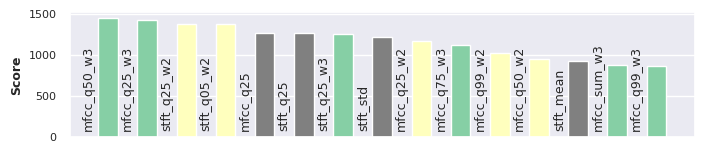

In [21]:
f_selector = SelectKBest(score_func=f_regression, k='all')
f_selector.fit(X_train, y_train)


M = 15
best_features = np.flip(np.argsort(f_selector.scores_)[-M:])

# ADD somo colors bitches
colors = ["gray"]
colors += sns.color_palette("Spectral", n_colors=3) #["gray", "b", "r", "g", "orange"]
bar_colors = []
for col in df_target_excluded.columns[best_features]:
    try:
        window = col.split("_")[-1]
        window = int(window[-1])        
    except ValueError as e:
        print(e)
        window = 0
    if window <= 4:
        bar_colors.append(colors[window])
    else:
        bar_colors.append(colors[0])

# Do the barplot

plt.figure(figsize=default_style.BAND_FULLSIZE_FIGURE)
plt.bar(range(M), f_selector.scores_[best_features], color=bar_colors, width=0.5)
plt.xticks([])
plt.ylabel('Score')

# Plot the names 
for i, kid in enumerate(best_features):
    if kid < len(df_target_excluded.columns):
        plt.annotate(df_target_excluded.columns[kid], (i-0.5, 120), rotation=90, ha="center", fontsize=9)
    else:
        print(f"kid {kid} was over range")

plt.savefig(os.path.join(IMAGE_FOLDER, 'kbest_features_stft_min.pdf'), format='pdf')
plt.show()

In [22]:
f_selector = SelectKBest(score_func=f_regression, k=30)
f_selector.fit(X_train, y_train)

X_train_reduced = f_selector.transform(X_train)
X_val_reduced = f_selector.transform(X_val)
X_to_predict_reduced = f_selector.transform(X_to_predict)

# selected columns
selected_indices = f_selector.get_support(indices=True)
# df_nz.drop(columns=[TARGET]).iloc[:, selected_indices].columns

## Now add back the categorical attributes

In [25]:
df_categories = pd.DataFrame()
for cat in categorical_attr_list:
    df_categories[cat] = pd.Categorical(df[categorical_attr_list]).codes



,vocal_channel,emotion,emotional_intensity,statement,repetition,actor,sex
0,6,6,6,6,6,6,6
1,1,1,1,1,1,1,1
2,2,2,2,2,2,2,2
3,5,5,5,5,5,5,5
4,3,3,3,3,3,3,3
5,0,0,0,0,0,0,0
6,4,4,4,4,4,4,4


## XGBoost

In [10]:
from sklearn.metrics import mean_squared_error, r2_score
from xgboost import XGBRegressor
import optuna

# objective function to be minimized
def objective_fun(trial):

    booster = trial.suggest_categorical('booster', ['gbtree', 'dart'])
    gamma = trial.suggest_float('gamma', 0, 5)
    max_depth = trial.suggest_int('max_depth', 3, 20)
    min_child_weight = trial.suggest_int('min_child_weight', 1, 3)
    subsample = trial.suggest_float('subsample', 0.4, 1)

    xgb = XGBRegressor(booster=booster, gamma=gamma, max_depth=max_depth, min_child_weight=min_child_weight, subsample=subsample)

    xgb.fit(X_train_reduced, y_train)
    y_pred = xgb.predict(X_valid_reduced)

    error = mean_squared_error(y_valid, y_pred)

    return error


study = optuna.create_study()
study.optimize(objective_fun, n_trials=150, n_jobs=-1)

[I 2023-07-12 16:45:13,385] A new study created in memory with name: no-name-35d09a16-8083-427d-9694-995c3b07da5d
[I 2023-07-12 16:45:16,919] Trial 1 finished with value: 0.06570793189944743 and parameters: {'booster': 'gbtree', 'gamma': 1.4113822469485964, 'max_depth': 9, 'min_child_weight': 2, 'subsample': 0.7705851093468765}. Best is trial 1 with value: 0.06570793189944743.
[I 2023-07-12 16:45:19,211] Trial 3 finished with value: 0.0708833450970573 and parameters: {'booster': 'dart', 'gamma': 2.535622732402074, 'max_depth': 9, 'min_child_weight': 1, 'subsample': 0.6835097918400873}. Best is trial 1 with value: 0.06570793189944743.
[I 2023-07-12 16:45:20,103] Trial 2 finished with value: 0.06355415937128778 and parameters: {'booster': 'gbtree', 'gamma': 1.4808130547832015, 'max_depth': 20, 'min_child_weight': 3, 'subsample': 0.8004329246461919}. Best is trial 2 with value: 0.06355415937128778.
[I 2023-07-12 16:45:21,683] Trial 4 finished with value: 0.06726065803710117 and parameters

[I 2023-07-12 16:45:53,710] Trial 31 finished with value: 0.06564591094168114 and parameters: {'booster': 'dart', 'gamma': 1.1008590930174962, 'max_depth': 13, 'min_child_weight': 2, 'subsample': 0.8493574538645032}. Best is trial 27 with value: 0.05638517256939576.
[I 2023-07-12 16:45:54,576] Trial 32 finished with value: 0.06315717585079228 and parameters: {'booster': 'dart', 'gamma': 1.2783771464788352, 'max_depth': 14, 'min_child_weight': 2, 'subsample': 0.8513258034400315}. Best is trial 27 with value: 0.05638517256939576.
[I 2023-07-12 16:45:56,252] Trial 33 finished with value: 0.06819799637187328 and parameters: {'booster': 'dart', 'gamma': 1.0872671723161438, 'max_depth': 13, 'min_child_weight': 2, 'subsample': 0.8438032373955865}. Best is trial 27 with value: 0.05638517256939576.
[I 2023-07-12 16:45:56,510] Trial 34 finished with value: 0.0613066321911413 and parameters: {'booster': 'dart', 'gamma': 0.3798276139381954, 'max_depth': 13, 'min_child_weight': 3, 'subsample': 0.84

[I 2023-07-12 16:46:19,915] Trial 62 finished with value: 0.05978754173280361 and parameters: {'booster': 'dart', 'gamma': 0.7346817115935078, 'max_depth': 9, 'min_child_weight': 3, 'subsample': 0.9133856399069018}. Best is trial 56 with value: 0.055744526287547315.
[I 2023-07-12 16:46:20,000] Trial 64 finished with value: 0.06378961247886392 and parameters: {'booster': 'dart', 'gamma': 0.4625285588746506, 'max_depth': 8, 'min_child_weight': 3, 'subsample': 0.9656628113649329}. Best is trial 56 with value: 0.055744526287547315.
[I 2023-07-12 16:46:21,890] Trial 65 finished with value: 0.06354633768300753 and parameters: {'booster': 'dart', 'gamma': 0.4481599342094488, 'max_depth': 5, 'min_child_weight': 3, 'subsample': 0.9367317719882539}. Best is trial 56 with value: 0.055744526287547315.
[I 2023-07-12 16:46:22,229] Trial 63 finished with value: 0.060490300438127136 and parameters: {'booster': 'dart', 'gamma': 0.959862839545877, 'max_depth': 18, 'min_child_weight': 3, 'subsample': 0.9

[I 2023-07-12 16:46:47,772] Trial 93 finished with value: 0.062154456224959916 and parameters: {'booster': 'dart', 'gamma': 0.09356655928998736, 'max_depth': 9, 'min_child_weight': 3, 'subsample': 0.9998759262727751}. Best is trial 87 with value: 0.05472172050088582.
[I 2023-07-12 16:46:47,841] Trial 94 finished with value: 0.06144304831347808 and parameters: {'booster': 'dart', 'gamma': 0.4920056231515248, 'max_depth': 9, 'min_child_weight': 3, 'subsample': 0.9991651756409033}. Best is trial 87 with value: 0.05472172050088582.
[I 2023-07-12 16:46:49,051] Trial 95 finished with value: 0.061365072803747804 and parameters: {'booster': 'dart', 'gamma': 0.2647435914108144, 'max_depth': 9, 'min_child_weight': 3, 'subsample': 0.9820552093444419}. Best is trial 87 with value: 0.05472172050088582.
[I 2023-07-12 16:46:49,386] Trial 96 finished with value: 0.06151377797714707 and parameters: {'booster': 'dart', 'gamma': 0.3042738517296994, 'max_depth': 9, 'min_child_weight': 3, 'subsample': 0.98

[I 2023-07-12 16:47:13,359] Trial 124 finished with value: 0.05881941405656312 and parameters: {'booster': 'dart', 'gamma': 0.47613540957184125, 'max_depth': 7, 'min_child_weight': 2, 'subsample': 0.9505355063173282}. Best is trial 116 with value: 0.05461694142657708.
[I 2023-07-12 16:47:13,899] Trial 125 finished with value: 0.05703138653735137 and parameters: {'booster': 'dart', 'gamma': 0.5082055668090294, 'max_depth': 7, 'min_child_weight': 2, 'subsample': 0.9874334981097942}. Best is trial 116 with value: 0.05461694142657708.
[I 2023-07-12 16:47:13,972] Trial 126 finished with value: 0.06320117105273708 and parameters: {'booster': 'dart', 'gamma': 0.4942051882707128, 'max_depth': 7, 'min_child_weight': 2, 'subsample': 0.9776638164016241}. Best is trial 116 with value: 0.05461694142657708.
[I 2023-07-12 16:47:14,926] Trial 127 finished with value: 0.058356257819119496 and parameters: {'booster': 'dart', 'gamma': 0.6566624719514359, 'max_depth': 7, 'min_child_weight': 2, 'subsample'

In [11]:
best_params = study.best_params

xgb = XGBRegressor(**best_params)
xgb.fit(X_train, y_train)

y_pred_test = xgb.predict(X_test)

nrmse = np.sqrt(mean_squared_error(y_test, y_pred_test)) / (np.max(y_test) - np.min(y_test))

print(best_params)
print('Normalized root mean squared error = %.4f' % nrmse)
print('R-squared = %.4f' % r2_score(y_test, y_pred_test))

{'booster': 'dart', 'gamma': 0.5819540409229472, 'max_depth': 8, 'min_child_weight': 3, 'subsample': 0.9894738123376842}
Normalized root mean squared error = 0.0844
R-squared = 0.8348


In [12]:
y_pred = xgb.predict(X_to_pred)
y_pred = np.power(10, y_pred)
y_pred

array([1.6036073e-02, 1.9578069e-02, 1.0201158e-02, ..., 1.1968597e-04,
       1.4173033e-04, 7.3944524e-05], dtype=float32)

In [13]:
# negative values predicted
np.count_nonzero(y_pred < 0)

0

In [14]:
df_zero_xgb = df_zero.copy()
df_xgb = df.copy()

df_zero_xgb[TARGET] = y_pred
df_xgb.update(df_zero_xgb)

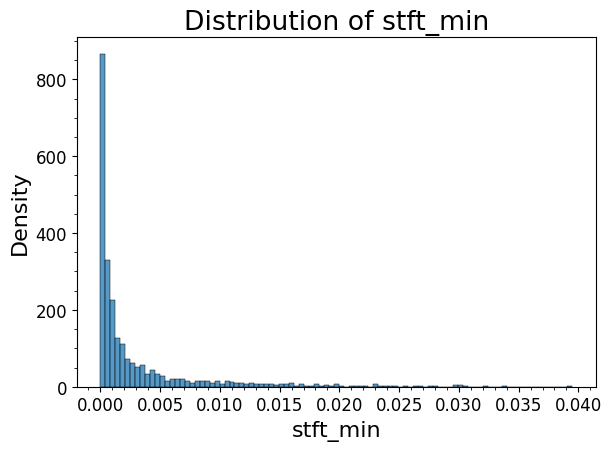

In [15]:
sns.histplot(data=df_xgb, x=TARGET, stat='density')
plt.xlabel(f'{TARGET}')
plt.ylabel('Density')
plt.title(f'Distribution of {TARGET}')
plt.savefig(os.path.join(IMAGE_FOLDER, 'xgboost_stft_min_distr.pdf'), format='pdf')
plt.show()

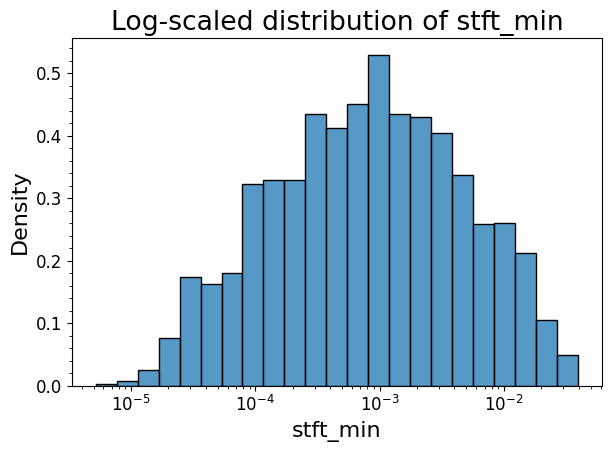

In [16]:
sns.histplot(data=df_xgb, x=TARGET, stat='density', log_scale=True)
plt.xlabel(f'{TARGET}')
plt.ylabel('Density')
plt.title(f'Log-scaled distribution of {TARGET}')
plt.savefig(os.path.join(IMAGE_FOLDER, 'xgboost_stft_min_logscale_distr.pdf'), format='pdf')
plt.show()

## Neural Network

In [17]:
import tensorflow
from keras import Sequential
from keras.layers import Dense

def create_model(trial):

    n_hidden = trial.suggest_int('n_hidden', 2, 5)
    n_units = trial.suggest_int('n_units', 32, 128)
    learning_rate = trial.suggest_float('learning_rate', 1e-5, 1e-1)

    model = Sequential()
    model.add(Dense(n_units, input_dim=X_train.shape[1], activation='relu'))

    for i in range(n_hidden):
        model.add(Dense(n_units, activation='relu'))

    model.add(Dense(1))
    model.compile(loss='mean_squared_error',
                  optimizer=tensorflow.keras.optimizers.legacy.Adam(learning_rate=learning_rate),
                  metrics=tensorflow.keras.metrics.MeanSquaredError())
    return model


# objective function to be minimized
def objective_fun(trial):

    model = create_model(trial)
    model.fit(X_train, y_train, epochs=30, batch_size=128, validation_data=(X_valid, y_valid), verbose=False)

    error = model.evaluate(X_valid, y_valid, verbose=False)[1]

    return error


study = optuna.create_study()
study.optimize(objective_fun, n_trials=150, n_jobs=-1)

2023-07-12 16:47:42.139453: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-07-12 16:47:42.631381: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-07-12 16:47:42.634139: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-12 16:47:44.366806: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
[I 2023-07-12 16:47:46,186] A new study created in memory with name: no-name-39f446e8-bbec-4381-9581-90e86cc383df
[I 2023-07-12 16:47:56,044] Trial 1 finished with value: 0.6042723655700684 and parameters: {'n_hidden': 4, 'n_units': 88, 'learning_rate': 0.07492805302294521}. Best is trial 1 

[I 2023-07-12 16:49:14,568] Trial 35 finished with value: 0.11156931519508362 and parameters: {'n_hidden': 3, 'n_units': 91, 'learning_rate': 0.024107083344860798}. Best is trial 26 with value: 0.08730602264404297.
[I 2023-07-12 16:49:17,969] Trial 36 finished with value: 0.09685343503952026 and parameters: {'n_hidden': 3, 'n_units': 91, 'learning_rate': 0.01921396122196267}. Best is trial 26 with value: 0.08730602264404297.
[I 2023-07-12 16:49:18,931] Trial 37 finished with value: 0.6082568168640137 and parameters: {'n_hidden': 3, 'n_units': 90, 'learning_rate': 0.0310398831918853}. Best is trial 26 with value: 0.08730602264404297.
[I 2023-07-12 16:49:22,737] Trial 38 finished with value: 0.13187554478645325 and parameters: {'n_hidden': 3, 'n_units': 112, 'learning_rate': 0.03123335998905604}. Best is trial 26 with value: 0.08730602264404297.
[I 2023-07-12 16:49:24,323] Trial 39 finished with value: 0.18196134269237518 and parameters: {'n_hidden': 4, 'n_units': 113, 'learning_rate': 0

[I 2023-07-12 16:50:46,344] Trial 74 finished with value: 0.09022025018930435 and parameters: {'n_hidden': 3, 'n_units': 115, 'learning_rate': 0.004912681469782592}. Best is trial 26 with value: 0.08730602264404297.
[I 2023-07-12 16:50:47,279] Trial 75 finished with value: 0.09423840045928955 and parameters: {'n_hidden': 3, 'n_units': 125, 'learning_rate': 0.0027730210843626797}. Best is trial 26 with value: 0.08730602264404297.
[I 2023-07-12 16:50:51,187] Trial 76 finished with value: 0.09004227072000504 and parameters: {'n_hidden': 3, 'n_units': 115, 'learning_rate': 0.012018997048956582}. Best is trial 26 with value: 0.08730602264404297.
[I 2023-07-12 16:50:54,810] Trial 78 finished with value: 0.1083555743098259 and parameters: {'n_hidden': 3, 'n_units': 115, 'learning_rate': 0.01023206937629893}. Best is trial 26 with value: 0.08730602264404297.
[I 2023-07-12 16:50:55,086] Trial 79 finished with value: 0.09939271211624146 and parameters: {'n_hidden': 3, 'n_units': 102, 'learning_r

[I 2023-07-12 16:52:12,951] Trial 112 finished with value: 0.09361928701400757 and parameters: {'n_hidden': 3, 'n_units': 124, 'learning_rate': 0.015381630727672641}. Best is trial 26 with value: 0.08730602264404297.
[I 2023-07-12 16:52:15,401] Trial 114 finished with value: 0.10207746922969818 and parameters: {'n_hidden': 3, 'n_units': 102, 'learning_rate': 0.009725279369680045}. Best is trial 26 with value: 0.08730602264404297.
[I 2023-07-12 16:52:17,907] Trial 115 finished with value: 0.095982126891613 and parameters: {'n_hidden': 3, 'n_units': 96, 'learning_rate': 0.008813943791721505}. Best is trial 26 with value: 0.08730602264404297.
[I 2023-07-12 16:52:20,219] Trial 113 finished with value: 0.09043525159358978 and parameters: {'n_hidden': 3, 'n_units': 81, 'learning_rate': 0.008275542919628988}. Best is trial 26 with value: 0.08730602264404297.
[I 2023-07-12 16:52:20,757] Trial 116 finished with value: 0.10086743533611298 and parameters: {'n_hidden': 3, 'n_units': 96, 'learning_

In [18]:
study.best_params

{'n_hidden': 3, 'n_units': 90, 'learning_rate': 0.005280697109018578}

In [19]:
model = create_model(study.best_trial)
model.fit(X_train, y_train, epochs=30, batch_size=128, validation_data=(X_valid, y_valid), verbose=False)

y_pred_test = model.predict(X_test)

nrmse = np.sqrt(mean_squared_error(y_test, y_pred_test)) / (np.max(y_test) - np.min(y_test))

print('Normalized root mean squared error = %.4f' % nrmse)
print('R-squared = %.4f' % r2_score(y_test, y_pred_test))

12/12 [==============================] - 0s 2ms/step
Normalized root mean squared error = 0.1134
R-squared = 0.7020


In [20]:
y_pred = model.predict(X_to_pred)
y_pred = np.power(10, y_pred)
y_pred

32/32 [==============================] - 0s 2ms/step


array([[1.0203294e-02],
       [1.1335000e-02],
       [8.6876182e-03],
       ...,
       [8.5812746e-05],
       [9.8609424e-05],
       [7.7260767e-05]], dtype=float32)

In [21]:
df_zero_ann = df_zero.copy()
df_ann = df.copy()

df_zero_ann[TARGET] = y_pred
df_ann.update(df_zero_ann)

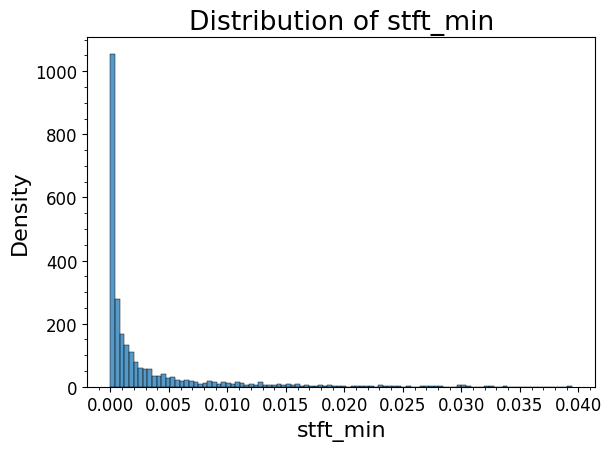

In [22]:
sns.histplot(data=df_ann, x=TARGET, stat='density')
plt.xlabel(f'{TARGET}')
plt.ylabel('Density')
plt.title(f'Distribution of {TARGET}')
plt.savefig(os.path.join(IMAGE_FOLDER, 'ann_stft_min_distr.pdf'), format='pdf')
plt.show()

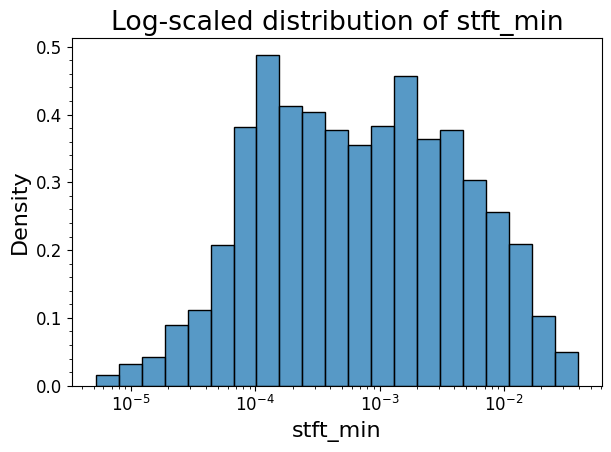

In [23]:
sns.histplot(data=df_ann, x=TARGET, stat='density', log_scale=True)
plt.xlabel(f'{TARGET}')
plt.ylabel('Density')
plt.title(f'Log-scaled distribution of {TARGET}')
plt.savefig(os.path.join(IMAGE_FOLDER, 'ann_stft_min_logscale_distr.pdf'), format='pdf')
plt.show()

In [24]:
pd.DataFrame(study.best_params, index=[0]).to_latex()

ImportError: Missing optional dependency 'Jinja2'. DataFrame.style requires jinja2. Use pip or conda to install Jinja2.